In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms 
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
#import pingouin as pg
import scipy.stats as ss
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1 Load Split Data

In [19]:
# 1 Load Split Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train_regression.csv') #IMPORTANT: 'y' is the T-Score, not the class.
y_test = pd.read_csv('y_test_regression.csv') #IMPORTANT: 'y' is the T-Score, not the class

# some models in scikit-learn expect the target variable y to be a one-dimensional array, but you might be passing a two-dimensional array (or column-vector) instead. You can use the ravel() function to convert y_train and y_test into one-dimensional arrays.
y_train = y_train.squeeze().values  # This converts the DataFrame to a numpy array
y_test = y_test.squeeze().values  # This converts the DataFrame to a numpy array

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2003, 9), (501, 9), (2003,), (501,))

In [20]:
X_train.head()

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,PAXMINSB,PAXMINLPA,PAXMINMPA,PAXMINVPA,PAXMINVVPA
0,76988.0,1.0,67.0,68.3,55.180460,271.081575,226.268674,20.398862,0.425658
1,82083.0,2.0,57.0,67.4,54.249962,349.396124,403.947424,111.523810,11.183867
2,75435.0,2.0,63.0,60.3,75.901543,298.740069,458.557302,63.265076,2.150472
3,76741.0,2.0,68.0,70.1,84.972456,257.353975,277.324868,45.859348,2.212542
4,78834.0,2.0,56.0,57.1,48.954254,330.458856,458.479079,84.496932,5.680614


Drop SEQN column

In [21]:
X_train = X_train.drop(['SEQN'], axis=1)
X_test = X_test.drop(['SEQN'], axis=1)

In [23]:
columns = X_train.columns
columns

Index(['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'PAXMINSB', 'PAXMINLPA', 'PAXMINMPA',
       'PAXMINVPA', 'PAXMINVVPA'],
      dtype='object')

# 2 Scale Normalization

In [24]:
# Instantiate an object of that class
scaler = StandardScaler() #MinMaxScaler() #RobustScaler() #MaxAbsScaler()

# Fit the transformer to the data (learning)
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assign
X_train = X_train_scaled
X_test = X_test_scaled

# 3 Multiple Linear Regression

In [25]:
# Initializing the linear model and scores array
linear_model = LinearRegression()

# Fitting the model with standardized training data
linear_model.fit(X_train, y_train)

# Calculating the cross-validation scores with 4 folds, and storing the R^2 values in the scores array
scores = cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=4)

# Printing the mean and max R^2 values from the cross-validation scores
print('R^2 Mean', ':', np.mean(scores))
print('R^2 Max', ':', np.max(scores))

R^2 Mean : 0.3005698206165365
R^2 Max : 0.3959696950428433


In [26]:
# Predicting the outcomes on the training set and storing them in linear_predictions_train
linear_predictions_train = linear_model.predict(X_train)

# Predicting the outcomes on the test set and storing them in linear_predictions_test
linear_predictions_test = linear_model.predict(X_test)

In [27]:
# Initializing a DataFrame to store coefficients
coefs = pd.DataFrame(index=columns)

# Extracting coefficients from the linear model and storing them in the DataFrame
coefs["coef"] = linear_model.coef_

# Adding the intercept of the model as a new row in the DataFrame
coefs.loc['Intercept'] = linear_model.intercept_

In [28]:
coefs

,coef
RIAGENDR,-0.161077
RIDAGEYR,-0.300393
BMXWT,0.511565
PAXMINSB,-0.046624
PAXMINLPA,-0.015629
PAXMINMPA,0.075530
PAXMINVPA,-0.034863
PAXMINVVPA,0.067780
Intercept,-0.575083


# Model Evaluation

- The coefficient of determination, R^2 provides a measure of how well the model's predictions match the actual data (explained variance).
- MSE is a measure of the average of the squares of the errors. It is a metric that tells you how close a model’s predictions are to the observed values.

In [29]:
# Calculating the R^2 value for the training set
r2_train = np.round(linear_model.score(X_train, y_train), 3)
print(f'R^2_train: {r2_train}')

# Calculating the R^2 value for the test set
r2_test = np.round(linear_model.score(X_test, y_test), 3)
print(f'R^2_test: {r2_test}')

R^2_train: 0.31
R^2_test: 0.362


In [30]:
# Calculate the MSE for the training set
mse_train = np.round(mean_squared_error(y_train, linear_predictions_train), 3)
print(f'MSE_train: {mse_train}')

# Calculate the MSE for the test set
mse_test = np.round(mean_squared_error(y_test, linear_predictions_test), 3)
print(f'MSE_test: {mse_test}')

MSE_train: 0.984
MSE_test: 1.006


# Visualization

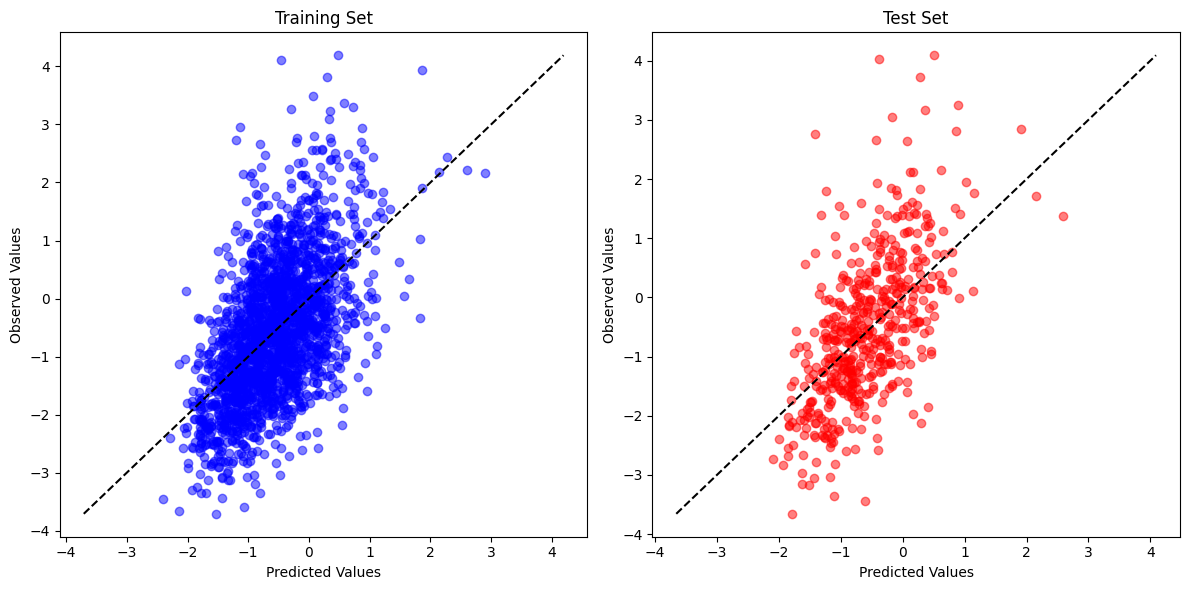

In [31]:
# For the training set
predicted_train = linear_predictions_train  # Your model's predictions on the training set
observed_train = y_train  # The actual outcomes in the training set

# For the test set
predicted_test = linear_predictions_test  # Your model's predictions on the test set
observed_test = y_test  # The actual outcomes in the test set


fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns layout for the subplots

# Left graph: Training set
axs[0].scatter(predicted_train, observed_train, color='blue', alpha=0.5)
axs[0].plot([min(observed_train), max(observed_train)], [min(observed_train), max(observed_train)], 'k--')  # Diagonal line
axs[0].set_title('Training Set')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Observed Values')

# Right graph: Test set
axs[1].scatter(predicted_test, observed_test, color='red', alpha=0.5)
axs[1].plot([min(observed_test), max(observed_test)], [min(observed_test), max(observed_test)], 'k--')  # Diagonal line
axs[1].set_title('Test Set')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Observed Values')

plt.tight_layout()
plt.show()


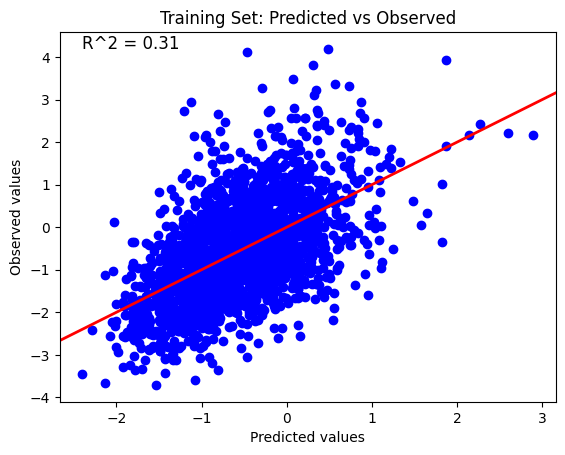

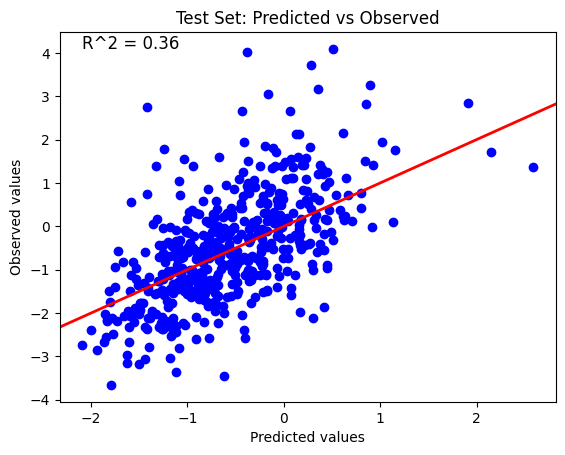

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Defining the function to plot the graphs
def plot_predicted_vs_observed(predicted, observed, title):
    plt.scatter(predicted, observed, color='blue')
    plt.title(title)
    plt.xlabel('Predicted values')
    plt.ylabel('Observed values')
    plt.axline([0, 0], [1, 1], linewidth=2, color='red')  # Line where predicted equals observed
    
    # Calculating and displaying the R^2 value
    r2 = r2_score(observed, predicted)
    plt.text(min(predicted), max(observed), f'R^2 = {r2:.2f}', fontsize=12, ha='left')
    
    plt.show()

# Using the function for the training set
plot_predicted_vs_observed(predicted_train, observed_train, 'Training Set: Predicted vs Observed')

# Using the function for the test set
plot_predicted_vs_observed(predicted_test, observed_test, 'Test Set: Predicted vs Observed')


# RANDOM FOREST

In [36]:
# Initializing a RandomForestRegressor model
rf_model = RandomForestRegressor()

# Fitting the model with the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test data
rf_tree_y_pred = rf_model.predict(X_test)

# Printing Mean Squared Error of the model's predictions
print("Mean squared error: %.4f" % mean_squared_error(y_test, rf_tree_y_pred))

# Printing R-squared value of the model's predictions
print("R squared: %.4f" % r2_score(y_true=y_test, y_pred=rf_tree_y_pred))

Mean squared error: 1.0466
R squared: 0.3359
